<img style="float: right" src="images/surfsara.png">
<br/>
<hr style="clear: both" />

# Machine Learning - decision trees in Spark
In this notebook, we'll try to assess the credit risk on a German credit data set. Based on a number of _features_, listed below, we wil need to train a machine learning model that predicts whether a person can be safely offered credit or not.

The structure of the data is shown in the table below. Notice that the first field is the _label_ (or _class_). This is the field we  will try to predict later. This value can be either 0 (false - high credit risk) or 1 (true - low credit risk). 
<br/>
<br/>
<img style="float: center" width="70%" src="https://mapr.com/blog/predicting-loan-credit-risk-using-apache-spark-machine-learning-random-forests/assets/blogimages/sparkmlgermancreditdata.png">
<br/>
<br/>
A more detailed description of the data, also listing the meaning of the attribute values, is available on the <a href="https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)">Machine Learning Repository</a> from the University of California, Irvine.

Because the label can only have two possible outcomes, this problem is known as a _binary classification problem_. To solve this problem, we must build a _classifier_ that takes all input features of the data set and successfully predicts the _label_ on new instances (persons we haven't seen before). 

Because the _label_ is known in advance, we will use a _supervised_ learning algorithm, in this case Random Forests. First, we use labeled data to train and build our model. This data contains features of each person and also the decision on creditability, the label that we have to predict for new data.

Please note that this dataset is very clean. In general you will spend a lot of time preprocessing your data before using it to train a model. In this example, we will only perform minimal preprocessing.

## Setting up Spark

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .getOrCreate()

We read in the csv data. We will let Spark figure out the schema:

In [2]:
credits_df = spark \
    .read \
    .format("csv") \
    .option("header", True) \
    .option("inferSchema", True) \
    .load("../data/germancredit.csv")

In [3]:
credits_df.printSchema()

root
 |-- creditability: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- history: integer (nullable = true)
 |-- purpose: integer (nullable = true)
 |-- amount: integer (nullable = true)
 |-- savings: integer (nullable = true)
 |-- employment: integer (nullable = true)
 |-- instPercent: integer (nullable = true)
 |-- sexMarried: integer (nullable = true)
 |-- guarantors: integer (nullable = true)
 |-- residenceDuration: integer (nullable = true)
 |-- assets: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- concCredit: integer (nullable = true)
 |-- apartment: integer (nullable = true)
 |-- credits: integer (nullable = true)
 |-- occupation: integer (nullable = true)
 |-- dependents: integer (nullable = true)
 |-- hasPhone: integer (nullable = true)
 |-- foreign: integer (nullable = true)



## Data exploration

Let's inspect the resulting DataFrame by converting it to a Pandas dataframe:

In [4]:
credits_df.toPandas().head(10)

,creditability,balance,duration,history,purpose,amount,savings,employment,instPercent,sexMarried,...,residenceDuration,assets,age,concCredit,apartment,credits,occupation,dependents,hasPhone,foreign
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2
5,1,1,10,4,0,2241,1,2,1,3,...,3,1,48,3,1,2,2,2,1,2
6,1,1,8,4,0,3398,1,4,1,3,...,4,1,39,3,2,2,2,1,1,2
7,1,1,6,4,0,1361,1,2,2,3,...,4,1,40,3,2,1,2,2,1,2
8,1,4,18,4,3,1098,1,1,4,2,...,4,3,65,3,2,2,1,1,1,1
9,1,2,24,2,3,3758,3,1,1,2,...,4,4,23,3,1,1,1,1,1,1


Spark can provide us with some information on the distribution of features. Usually you would perform a more extensive exploration of the data first. For example, we often calculate correlations between features to investigate the underlying structure of the data. Here we do all of this very briefly.

In the cell below, we calculate some descriptive statistics for the `amount` and `age` features:

In [5]:
credits_df.describe("amount", "age").toPandas()

,summary,amount,age
0,count,1000,1000
1,mean,3271.248,35.542
2,stddev,2822.7517598956515,11.352670131696735
3,min,250,19
4,max,18424,75


Below we do some more descriptive analytics on the relation between creditability and the amount of credit. First, we look at the average amount of credit per creditability class:

In [6]:
credits_df.groupBy("creditability").agg({"amount" : "avg"}).toPandas()

,creditability,avg(amount)
0,1,2985.442857
1,0,3938.126667


As you can see, persons with better creditability (1) usually have a lower amount of credit.

We can also visualise the amount of credit per class in a box plot using the [`seaborn`](https://seaborn.pydata.org/generated/seaborn.boxplot.html) plotting library:

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


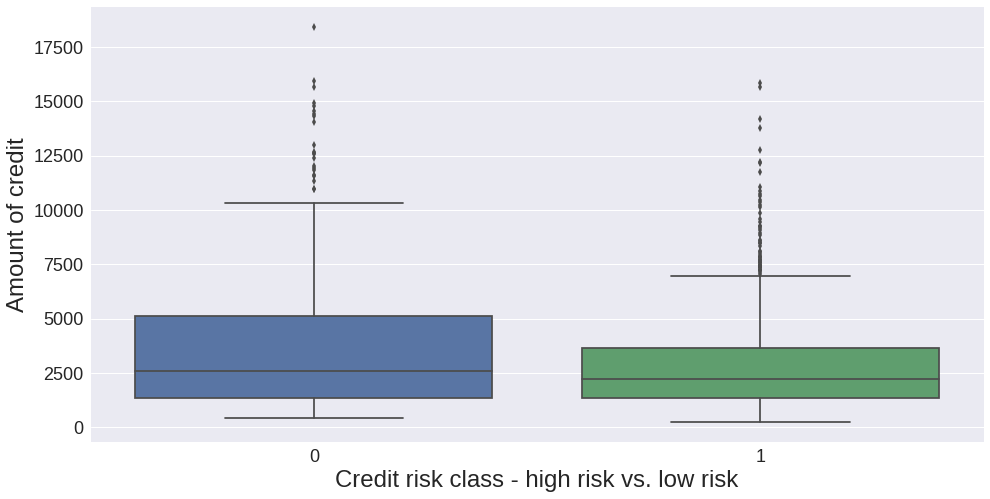

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

plt.figure(figsize=(16, 8))
sns.boxplot(data=credits_df.toPandas(), x='creditability', y='amount')
plt.ylabel('Amount of credit')
plt.xlabel('Credit risk class - high risk vs. low risk');

We can also create a table that lists the number of high risk and low risk persons by the status of their checking account (the `balance` feature). We won't ask you to reproduce the following code, but it will give you an idea of the data wrangling you'll have to perform to get insights into your data set:

In [8]:
import pyspark.sql.functions as F
from pyspark.sql.types import StringType

# For information on the mapping between the checking account attribute's value and its meaning, see:
# https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

CHECKING_ACCOUNT_STATUS = {
    1: '< 0 DM',
    2: '0 <= ... < 200 DM',
    3: '... >= 200 DM',
    4: 'no checking account'
}

checking_account_status = F.udf(lambda index: CHECKING_ACCOUNT_STATUS[index], StringType())

credits_df \
    .groupBy('balance') \
    .pivot('creditability') \
    .count() \
    .withColumnRenamed('0', 'high_risk') \
    .withColumnRenamed('1', 'low_risk') \
    .orderBy('balance', ascending=False) \
    .withColumn('checking_account_status', checking_account_status('balance')) \
    .toPandas()

,balance,high_risk,low_risk,checking_account_status
0,4,46,348,no checking account
1,3,14,49,... >= 200 DM
2,2,105,164,0 <= ... < 200 DM
3,1,135,139,< 0 DM


## Data preprocessing

We will need to make a decision on what features to include for our model training. We put these in a list. Please note that we will select all features in this case. Normally a selection is made based on informative value and relevance.

In [9]:
feature_column_names = [
    "balance", "duration", "history", "purpose", "amount",
    "savings", "employment", "instPercent", "sexMarried",
    "guarantors", "residenceDuration", "assets",  "age", 
    "concCredit", "apartment", "credits","occupation", 
    "dependents",  "hasPhone", "foreign"
]

The algorithm wants the data set but also needs the feature in the form of a feature vector. Spark has a helper class for this: [`VectorAssembler`](https://spark.apache.org/docs/2.1.1/ml-features.html#vectorassembler). We use it to put our features in the dataset under the column `features`.

After you execute the next cell and scroll to the right, you will see that the feature vector has been added as the last column of the data frame.

In [10]:
from pyspark.ml.feature import VectorAssembler  

assembler = VectorAssembler(inputCols=feature_column_names, outputCol="features")
features_df = assembler.transform(credits_df)
features_df.toPandas().head()

,creditability,balance,duration,history,purpose,amount,savings,employment,instPercent,sexMarried,...,assets,age,concCredit,apartment,credits,occupation,dependents,hasPhone,foreign,features
0,1,1,18,4,2,1049,1,2,4,2,...,2,21,3,1,1,3,1,1,1,"[1.0, 18.0, 4.0, 2.0, 1049.0, 1.0, 2.0, 4.0, 2..."
1,1,1,9,4,0,2799,1,3,2,3,...,1,36,3,1,2,3,2,1,1,"[1.0, 9.0, 4.0, 0.0, 2799.0, 1.0, 3.0, 2.0, 3...."
2,1,2,12,2,9,841,2,4,2,2,...,1,23,3,1,1,2,1,1,1,"[2.0, 12.0, 2.0, 9.0, 841.0, 2.0, 4.0, 2.0, 2...."
3,1,1,12,4,0,2122,1,3,3,3,...,1,39,3,1,2,2,2,1,2,"[1.0, 12.0, 4.0, 0.0, 2122.0, 1.0, 3.0, 3.0, 3..."
4,1,1,12,4,0,2171,1,3,4,3,...,2,38,1,2,2,2,1,1,2,"[1.0, 12.0, 4.0, 0.0, 2171.0, 1.0, 3.0, 4.0, 3..."


By default, Spark will consider all numeric features as continuous variables. However, many features in the data set are actually categorical. Spark's [`VectorIndexer`](https://spark.apache.org/docs/2.1.1/ml-features.html#vectorindexer) will automatically detect these categorical features and annotate them as such in the DataFrame:

In [11]:
from pyspark.ml.feature import VectorIndexer

indexer = VectorIndexer(maxCategories=11, inputCol='features', outputCol='features_indexed')
model = indexer.fit(features_df)
features_df = model.transform(features_df)
features_df.head()

Row(creditability=1, balance=1, duration=18, history=4, purpose=2, amount=1049, savings=1, employment=2, instPercent=4, sexMarried=2, guarantors=1, residenceDuration=4, assets=2, age=21, concCredit=3, apartment=1, credits=1, occupation=3, dependents=1, hasPhone=1, foreign=1, features=DenseVector([1.0, 18.0, 4.0, 2.0, 1049.0, 1.0, 2.0, 4.0, 2.0, 1.0, 4.0, 2.0, 21.0, 3.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0]), features_indexed=DenseVector([0.0, 18.0, 4.0, 2.0, 1049.0, 0.0, 1.0, 3.0, 1.0, 0.0, 3.0, 1.0, 21.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0]))

Apart from the new column, called `features_indexed`, it is not immediately obvious what has changed. VectorIndexer will do two things:

* transform any values in a column with fewer than `maxCategories` distinct values into zero-indexed values;
* annotate categorical features in the DataFrame's schema metadata.

The latter is visible when we look at the metadata for the last column (i.e. the `features_indexed`) column generated by `VectorIndexer`:

In [12]:
features_df.schema[-1].metadata

{'ml_attr': {'attrs': {'binary': [{'idx': 17,
     'name': 'dependents',
     'vals': ['1.0', '2.0']},
    {'idx': 18, 'name': 'hasPhone', 'vals': ['1.0', '2.0']},
    {'idx': 19, 'name': 'foreign', 'vals': ['1.0', '2.0']}],
   'nominal': [{'idx': 0,
     'name': 'balance',
     'ord': False,
     'vals': ['1.0', '2.0', '3.0', '4.0']},
    {'idx': 2,
     'name': 'history',
     'ord': False,
     'vals': ['0.0', '1.0', '2.0', '3.0', '4.0']},
    {'idx': 3,
     'name': 'purpose',
     'ord': False,
     'vals': ['0.0',
      '1.0',
      '2.0',
      '3.0',
      '4.0',
      '5.0',
      '6.0',
      '8.0',
      '9.0',
      '10.0']},
    {'idx': 5,
     'name': 'savings',
     'ord': False,
     'vals': ['1.0', '2.0', '3.0', '4.0', '5.0']},
    {'idx': 6,
     'name': 'employment',
     'ord': False,
     'vals': ['1.0', '2.0', '3.0', '4.0', '5.0']},
    {'idx': 7,
     'name': 'instPercent',
     'ord': False,
     'vals': ['1.0', '2.0', '3.0', '4.0']},
    {'idx': 8,
     'name':

As you can see, the column's metadata contains a `nominal` entry containing information on the nominal (i.e. categorical) attributes generated by `VectorIndexer`, with a list of values this attribute can take. Based on this metadata, Spark will distinguish between numeric and categorical values in the data set.

## Model training

Then we take the data set and split it randomly in a training part (80% of the data) and a test part (20%).
We train our model on the training data and test our performance on the test data later.

In [16]:
train_data, test_data = features_df.randomSplit([0.8, 0.2], 12345)
train_data.count(), test_data.count()

(787, 213)

The following cell trains a decision tree on our preprocessed data. It will take all preprocessed features (`features_indexed`) and label column (`creditability`) as input, and return a model by calling `fit`. Note that we set the maximum depth of the tree to five levels deep.

In [17]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol='features_indexed', labelCol="creditability", maxDepth=5)
model = dt.fit(train_data)
model

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_466ab2488d6ab0258257) of depth 5 with 57 nodes

Our model has been built, and we can now transform our test data set to obtain predictions.

The predictions show two probabilities, one for 0 (high credit risk) and one for 1 (low credit risk), as well as the final classification `prediction` (0 or 1):

In [15]:
predictions = model.transform(test_data)
predictions.toPandas()[['probability', 'prediction']].head(10)

,probability,prediction
0,"[0.264150943396, 0.735849056604]",1.0
1,"[1.0, 0.0]",0.0
2,"[0.125, 0.875]",1.0
3,"[0.264150943396, 0.735849056604]",1.0
4,"[0.264150943396, 0.735849056604]",1.0
5,"[0.264150943396, 0.735849056604]",1.0
6,"[0.264150943396, 0.735849056604]",1.0
7,"[0.125, 0.875]",1.0
8,"[0.264150943396, 0.735849056604]",1.0
9,"[0.692307692308, 0.307692307692]",0.0


## Model evaluation
In order to evaluate the test set predictions, we will use an evaluator. Since this is a binary classification problem, we will use Spark's `BinaryClassificationEvaluator`. There are a number of evaluation metrics we can choose from, and in this case we will use the area under the ROC curve:

In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='creditability')
evaluator.evaluate(predictions) 

0.7077922077922076

### Model inspection

We can plot the the importance of each feature using seaborn in order to see which features are informative for prediction.

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


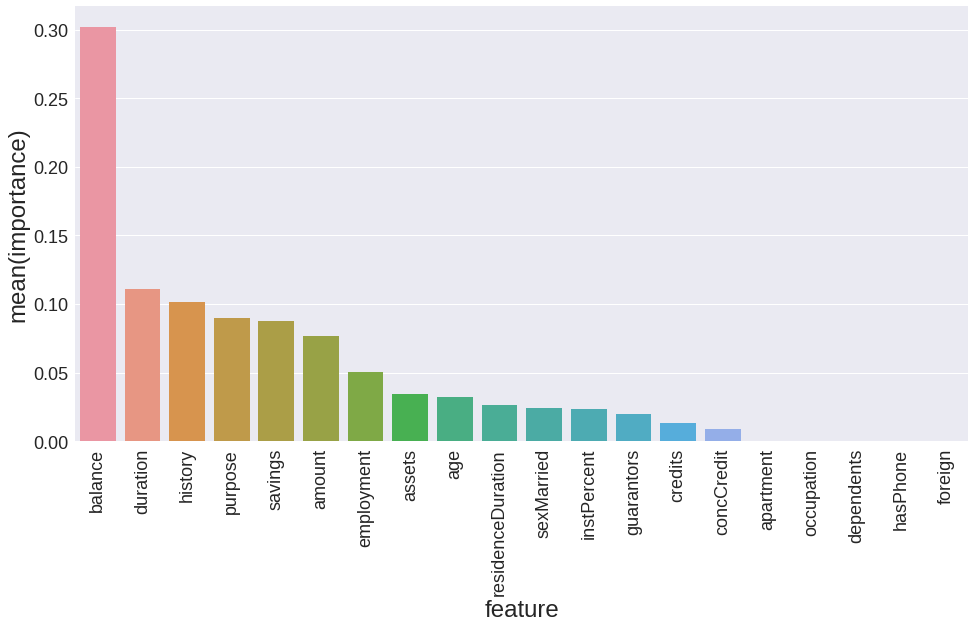

In [19]:
import pandas as pd
import matplotlib as mpl

importances_df = pd \
    .DataFrame({'importance': model.featureImportances.toArray(), 'feature': feature_column_names}) \
    .sort_values('importance', ascending=False)

plt.figure(figsize=(16, 8))    
sns.barplot(data=importances_df, x='feature', y='importance')
plt.xticks(rotation=90, fontsize=18);

We can also print out the decision tree model:

In [20]:
import string

tree_model_string = model.toDebugString
for index, column_name in enumerate(feature_column_names):
    tree_model_string = tree_model_string.replace(
        'feature {} '.format(index),
        '{} '.format(column_name)
    )

print(tree_model_string)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_466ab2488d6ab0258257) of depth 5 with 57 nodes
  If (balance in {0.0,1.0,2.0})
   If (duration <= 21.0)
    If (history in {0.0,1.0})
     If (purpose in {0.0,5.0,6.0})
      Predict: 0.0
     Else (purpose not in {0.0,5.0,6.0})
      If (sexMarried in {0.0,1.0})
       Predict: 0.0
      Else (sexMarried not in {0.0,1.0})
       Predict: 1.0
    Else (history not in {0.0,1.0})
     If (purpose in {4.0,6.0,7.0,9.0})
      If (age <= 47.0)
       Predict: 0.0
      Else (age > 47.0)
       Predict: 1.0
     Else (purpose not in {4.0,6.0,7.0,9.0})
      If (assets in {3.0})
       Predict: 0.0
      Else (assets not in {3.0})
       Predict: 1.0
   Else (duration > 21.0)
    If (savings in {1.0,2.0,3.0,4.0})
     If (amount <= 1374.0)
      If (savings in {1.0,4.0})
       Predict: 0.0
      Else (savings not in {1.0,4.0})
       Predict: 1.0
     Else (amount > 1374.0)
      If (history in {0.0,1.0,3.0,4.0})
       Predict: 1.0